# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd

In [2]:
import datetime as dt

In [3]:
import matplotlib.pyplot as plt 


In [ ]:
try:
    dirty_data = pd.read_csv('/datas/real_estate_data.csv', sep='\t')
except:
    dirty_data = pd.read_csv('C\\da\\real_estate_data.csv', sep='\t')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


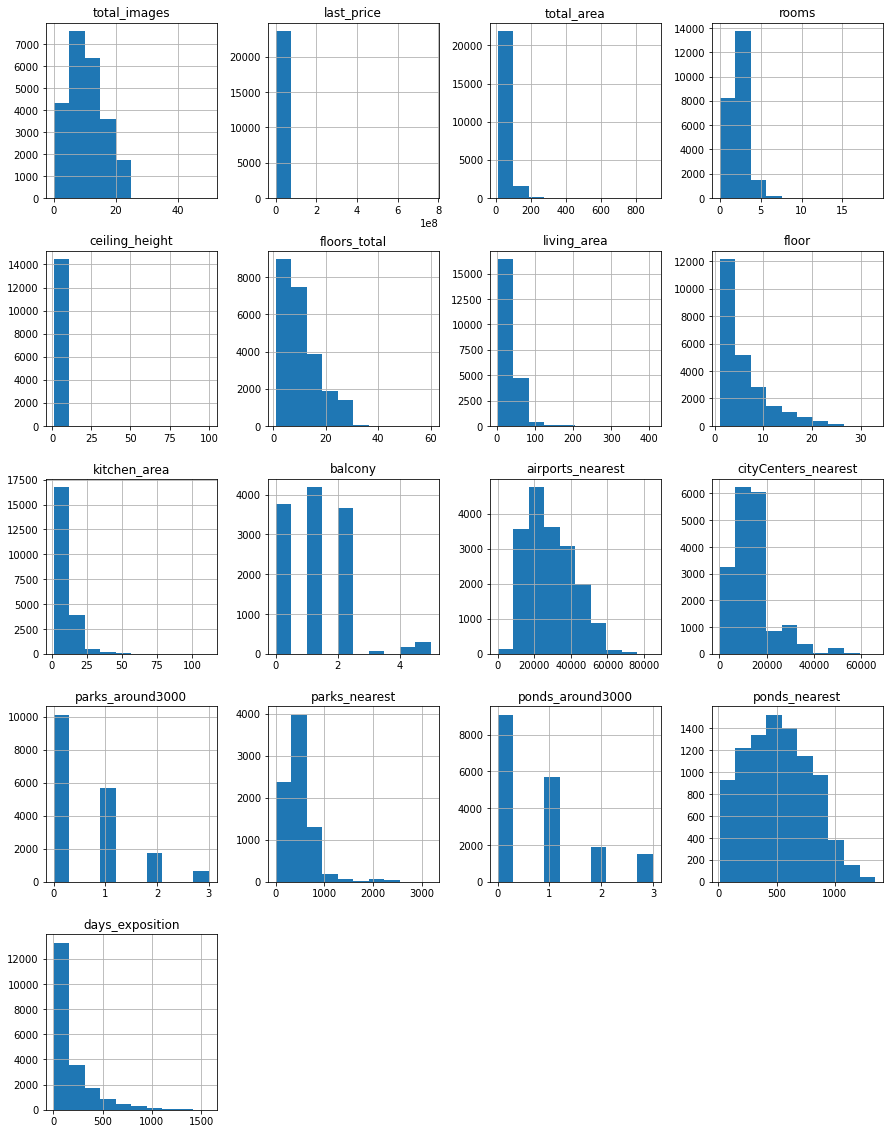

In [4]:
display(dirty_data.head())
dirty_data.info
dirty_data.hist(figsize=(15, 20))
plt.show()

При выводе таблицы и гистограм параметров сраз видно, что данные имеют пропуски и аномалии. 

# Выполните предобработку данных

In [5]:
dirty_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
dirty_data['balcony'] = dirty_data['balcony'].fillna(0)
dirty_data['parks_around3000'] = dirty_data['parks_around3000'].fillna(0)
dirty_data['ponds_around3000'] = dirty_data['ponds_around3000'].fillna(0)
dirty_data['is_apartment'] = dirty_data['is_apartment'].fillna(False)
mean_kitchen_area = (dirty_data['kitchen_area']/dirty_data['total_area']).mean()
dirty_data['kitchen_area'] = round(dirty_data['kitchen_area'].fillna(dirty_data['total_area']*mean_kitchen_area), 2)
mean_living_area = (dirty_data['living_area']/dirty_data['total_area']).mean()
dirty_data['living_area'] = round(dirty_data['living_area'].fillna(dirty_data['total_area']*mean_living_area), 2)
dirty_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
data = dirty_data.dropna(subset=['locality_name']) 
data = data.dropna(subset=['floors_total'])

count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

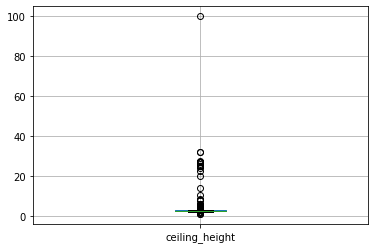

In [8]:
display(data['ceiling_height'].describe())
data.boxplot(column=['ceiling_height'])

В процессе анализа датафрейма были обнаружены аномалии в столбце 'ceiling_height' - одно неправдоподобно большое значение и некоторое количество аномалий, которые были внесены с ошибкой (у них неверно указана десятичная часть, т.к. очень сомнительно что высота потолков помещения может быть выше 10 м.  

<AxesSubplot:>

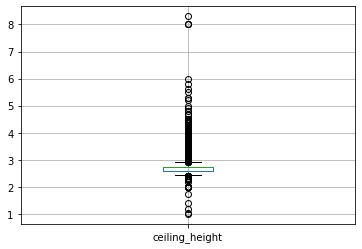

In [9]:
data = data.loc[data['ceiling_height'] != 100]
def correct_height(x):
    if x >= 10:
        return x * 0.1
    else:
        return x
data['ceiling_height'] = data['ceiling_height'].apply(correct_height)
data['ceiling_height'] = round(data['ceiling_height'].fillna(data['ceiling_height'].mean()), 2)
data.boxplot(column=['ceiling_height'])

Обработаны пропуски в колонках на основе следующих гипотез:
1) В столбце 'balcony' пропуски означают, что балкона в квартире нет. Поэтому заменяем пропуски на "0".\
2) В столбце 'is_apartment' указаны является ли помещение апартаментами. Исходя из кол-ва пропусков можно сделать вывод, что в\ объявлении просто не отмечали помещение как апартаменты. Поэтому присваеваем пропускам значение - False, т.е. что это жилое\ помещение.\
3) В колонках 'locality_name' и 'floors_total' сложно определить какие данные должны были быть на месте пропусков и количество пропусков небольшое относительно всего объема данных, поэтому просто удаляем их.\
4) Пропуски в living_area и kitchen_area появились скорее всего из-за того, что продавцы не указали эти данные и написали в\ объявлении только общую площадь квартиры. Точно определить эти параметры не получиться, т.к. сумма показателей не совпадает с total_area. Оставляем пропуски незаполненными.\
5) В колонках parks_around3000 и ponds_around3000 одинаковое кол-во пропусков. Возможно, что рядом нет этих объектов и поэтому было пропущено заполнение этих значений. Заполняем их "0"\
6)Пропуски в airports_nearest, cityCenters_nearest, , parks_nearest,  и ponds_nearest могут быть допущены из-за ошибки алгоритма (могут быть неверно настроены модели геопозиционирования, рассчета расстояния или нет данных о населенном пункте для рассчетов). Заполнить значения на основе датафрейма нельзя, а для удаления - строк слишком много. Оставляем пропуски для дальнейшего улучшения алгоритмов сбора и расчетов данных.\
7)Пропуски в days_exposition вероятно возникли из-за того, что объявление еще было размещено на момент архивации данных.\
8) Пропуски в 'ceiling_height' заполнены средним значением, т.к. при изучени числовых показателей средней, медианы и квартилей видим, что данные однородны. 

In [10]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [11]:
data['is_apartment'] = data['is_apartment'].replace(0, False)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data[['floors_total','balcony', 'parks_around3000', 'parks_around3000']] = \
data[['floors_total','balcony', 'parks_around3000', 'parks_around3000']].astype(int)
display(data.dtypes)

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Для дальнейшей корректной работы с данными привели типы данных в столбцах к верным форматам:
- 'is_apartment' - это булев тип данных;
- 'first_day_exposition' - это дата, приводим ее к этому типу данных;
- 'floors_total','balcony', 'parks_around3000', 'parks_around3000' - не могут быть дробными значениями, поэтому приводим их к типу int64.

In [12]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок', 'деревня', 'село','городской', 'городского типа','при железнодорожной станции', 'коттеджный','садовое товарищество','садоводческое некоммерческое товарищество'], '',
regex=True)
) 
display(data['locality_name'].unique())

array(['Санкт-Петербург', ' Шушары', '  Янино-1', ' Парголово', ' Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', ' Кудрово',
       'Коммунар', 'Колпино', '  Красный Бор', 'Гатчина', ' Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', ' Новое Девяткино',
       ' Металлострой', '  Лебяжье', '  Сиверский', ' Молодцово',
       '  Кузьмоловский', ' Новая Ропша', 'Павловск', ' Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       ' Куттузи', ' Аннино', '  Ефимовский', ' Плодовое', ' Заклинье',
       ' Торковичи', ' Первомайское', 'Красное Село', ' Понтонный',
       'Сясьстрой', ' Старая', ' Лесколово', ' Новый Свет', 'Сланцы',
       ' Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', ' Оржицы', ' Кальтино', 'Кудрово',
       ' Романовка', ' Бугры', '  Рощино', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', ' Павлово', ' Оредеж', ' Копорье', ' Молодежное',
       'Тихвин', ' П

In [13]:
#Код ревьюера
data.loc[data['locality_name'].str.contains('Рябово') & data['locality_name'].notna(), 'locality_name']

1611       Рябово
3930       Рябово
6465       Рябово
11118      Рябово
Name: locality_name, dtype: object

In [14]:
display(data.head())
data.info()
display(round(len(data)/len(dirty_data)*100, 2))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.73,11,18.6,1,False,...,11.00,2,Шушары,12817.0,18603.0,0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.73,5,34.3,4,False,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.73,14,89.8,9,False,...,29.79,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23564 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23564 non-null  int64         
 1   last_price            23564 non-null  float64       
 2   total_area            23564 non-null  float64       
 3   first_day_exposition  23564 non-null  datetime64[ns]
 4   rooms                 23564 non-null  int64         
 5   ceiling_height        23564 non-null  float64       
 6   floors_total          23564 non-null  int64         
 7   living_area           23564 non-null  float64       
 8   floor                 23564 non-null  int64         
 9   is_apartment          23564 non-null  bool          
 10  studio                23564 non-null  bool          
 11  open_plan             23564 non-null  bool          
 12  kitchen_area          23564 non-null  float64       
 13  balcony         

99.43

Данные очищены от пропусков, где это возможно заполнены. Отброшено менее 5% от данных - это допустимо. Дубликаты устранены.\
Типы даннных приведены к соответствию.

# Добавили в таблицу новые столбцы

In [15]:
data['price_1m'] = round(data['last_price']/data['total_area'], 2)
data['week_day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif (row['floor'] == row['floors_total'])&(row['floor']!=1):
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

data['cityCenters_nearest_km']= round(data['cityCenters_nearest']*0.001)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1m,week_day,month,year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.73,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.73,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.73,14,89.8,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


Добавлены колонки: с ценой одного квадратного метра, днем недели, месяцем продажи, годом продажи, расстояние до цента грода в км. Эта информация будет необходима для дальнейшей оценки взаимосвязей параметров с ценой объектов. 

# Проведите исследовательский анализ данных

In [16]:
display(round(data.describe(), 2))

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1m,week_day,month,year,cityCenters_nearest_km
count,23564.00,2.356400e+04,23564.00,23564.00,23564.00,23564.00,23564.00,23564.00,23564.00,23564.00,...,23564.00,8029.00,23564.00,9035.00,20393.00,23564.00,23564.00,23564.00,23564.00,18063.00
mean,9.88,6.539699e+06,60.32,2.07,2.73,10.68,34.56,5.88,10.57,0.59,...,0.47,490.61,0.59,518.34,180.75,99384.59,2.57,6.40,2017.37,14.19
std,5.68,1.091103e+07,35.66,1.08,0.23,6.59,22.35,4.87,6.09,0.96,...,0.75,341.58,0.88,277.98,219.74,50284.86,1.79,3.49,1.04,8.62
min,0.00,1.219000e+04,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,...,0.00,1.00,0.00,13.00,1.00,111.83,0.00,1.00,2014.00,0.00
25%,6.00,3.400000e+06,40.00,1.00,2.60,5.00,19.00,2.00,7.00,0.00,...,0.00,288.00,0.00,293.00,45.00,76565.22,1.00,3.00,2017.00,9.00
50%,9.00,4.646000e+06,52.00,2.00,2.73,9.00,30.00,4.00,9.00,0.00,...,0.00,455.00,0.00,503.00,95.00,95000.00,3.00,6.00,2017.00,13.00
75%,14.00,6.790000e+06,69.70,3.00,2.73,16.00,42.10,8.00,12.00,1.00,...,1.00,612.00,1.00,730.00,231.00,114213.20,4.00,10.00,2018.00,16.00
max,50.00,7.630000e+08,900.00,19.00,8.30,60.00,409.70,33.00,112.00,5.00,...,3.00,3190.00,3.00,1344.00,1580.00,1907500.00,6.00,12.00,2019.00,66.00


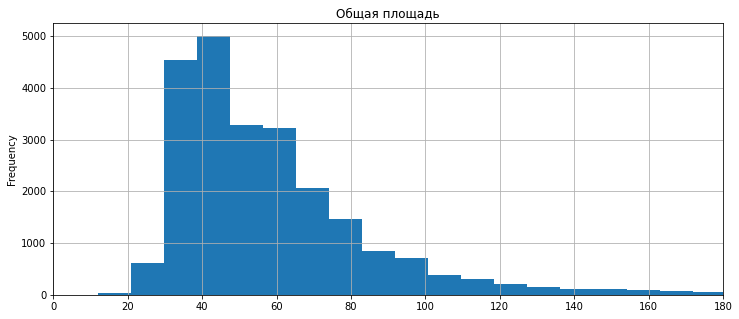

In [17]:
data['total_area'].plot(kind='hist', title='Общая площадь', bins=100, grid=True, xlim=(0,180), figsize=(12,5))
data.drop(data.loc[data['total_area']>175].index, inplace=True)

Чаще всего в объявлениях встречаются квартиры с площадью от 40 до 50 кв.м. Распределение общей площади выглядит нормально, нет пиков аномальных значений. Но очень небольшое кол-во объявлений с площадью свыше 175 кв.м. образуют длинный хвост. Удалим их для удобства работы. 

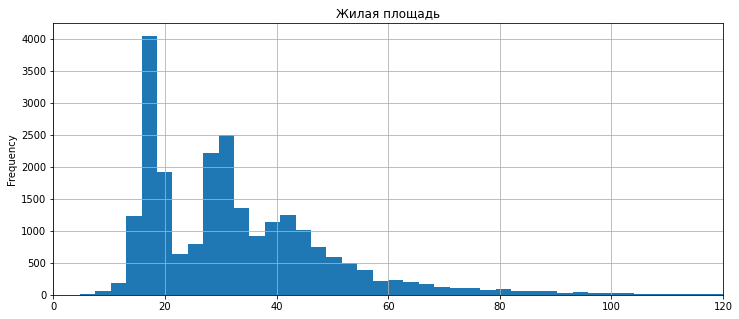

In [18]:
data['living_area'].plot(kind='hist', title='Жилая площадь', bins=50, grid=True, xlim=(0,120), figsize=(12,5))
data.drop(data.loc[data['living_area']>120].index, inplace=True)

На графике вновь видим длинный хвост больших значений с небольшой частотой появления. Отсечем все значения свыше 120 кв.м. 
Видим 2 пика значений, что может указывать на аномалии распределения - это может быть связано с тем, что для большого числа объявлений указана только общая площадь помещения. Возможно продавцы не знают как рассчитывать эту площать.\
Чаще всего встречаются объявления с жилой площадью около 15 кв.м, а за ним самая популярная площадь - 30 кв.м.

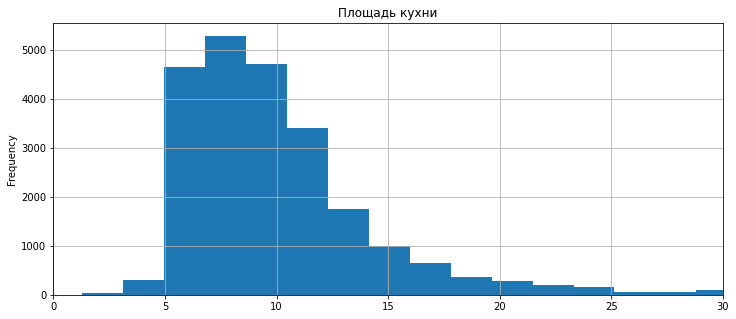

In [19]:
data['kitchen_area'].plot(kind='hist', title='Площадь кухни', bins=50, grid=True, xlim=(0,30), figsize=(12,5))
data.drop(data.loc[data['kitchen_area']>30].index, inplace=True)

График площади кухни имеет стандартное распределение, со характерным для этой выборки длинным хвостом больших значений площади. Самая часто встречающаяся площадь кухни - 8 кв.м.

count    22968.00
mean         5.73
std          4.75
min          0.43
25%          3.40
50%          4.58
75%          6.50
max        124.00
Name: last_price_bln, dtype: float64

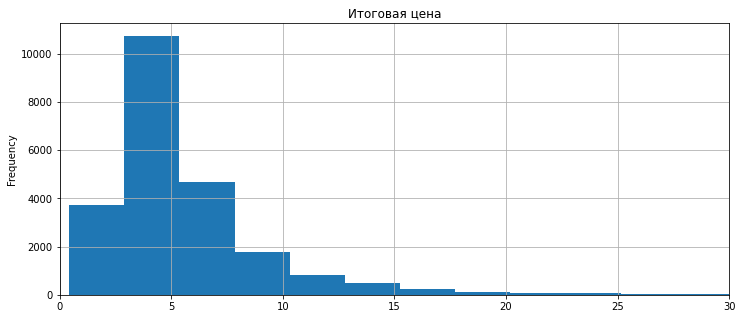

In [20]:
data['last_price_bln'] = data['last_price']/1000000
display(round(data['last_price_bln'].describe(), 2))
data['last_price_bln'].plot(kind='hist', title='Итоговая цена', bins=50, xlim=(0,30), grid=True, figsize=(12,5))
data.drop(data.loc[data['last_price_bln']>30].index, inplace=True)

Для работы с большими суммами введем столбец 'last_price_bln', где будут указаны суммы в млн. рублей.\
На графике и в числовой характеристике данных, мы увидели выбросы свыше 30 млн., которые были удалены.\
Самый распространенный диапазон цены - от 3 до 5 млн.рублей.

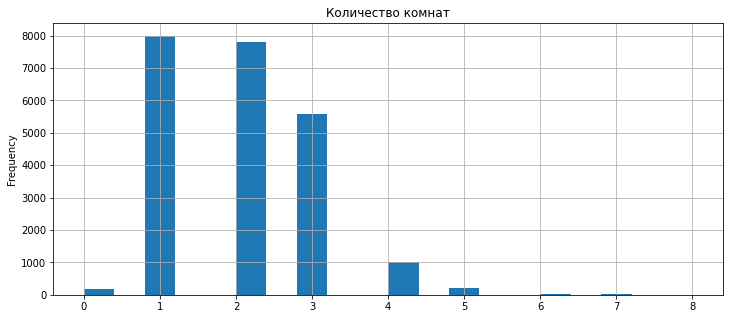

In [21]:
data['rooms'].plot(kind='hist', bins=20, grid=True, title='Количество комнат', figsize=(12,5))
#display(data['rooms'].unique())
data.drop(data.loc[data['rooms']==0].index, inplace=True)


На графике мы видим аномалию - это квартиры с 0 комнат. Такого не может быть, поэтому удаляем эти строки. Больше всего объявлений квартир с 1 или 2 комнатами. 

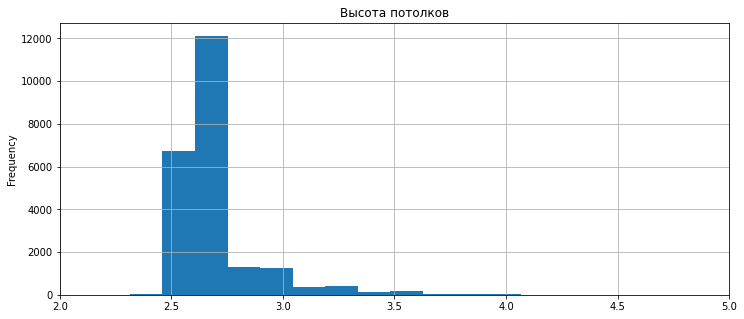

In [22]:
data['ceiling_height'].plot(kind='hist', bins=50, title='Высота потолков', xlim=(2,5), grid=True, figsize=(12,5))
plt.show()

После очистки данных, видно, что распределение высоты потолков идет от 2,5 до 3,0 метров. Значения выше и ниже встречаются очень редко. Это связано с тем, что при постройке жилья используют стандарты, установленные государством. 

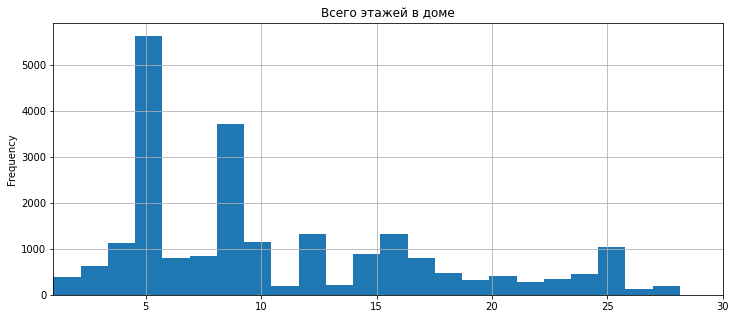

In [23]:
data['floors_total'].plot(kind='hist', bins=50, grid=True, title='Всего этажей в доме', xlim=(1,30), figsize=(12,5))
plt.show()

Отсекли очень редкие значения на графике - все что выше 30 этажа. Видно, что наиболее частая этажность зданий - 5, 9, 12, 16, 25 этажей (на графике отражены пиками значений). Это связано со стандартной застройкой городов в России - 5 и 9 этажные дома самые распространенные.  

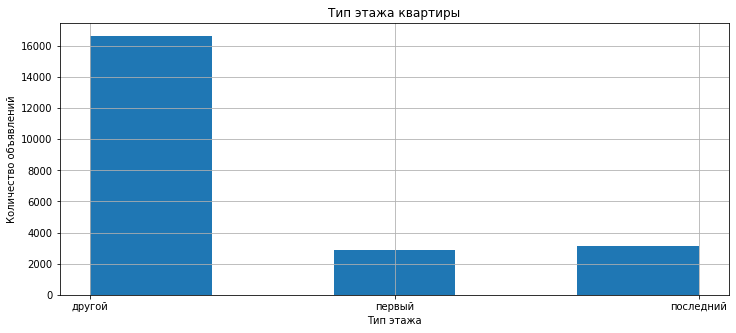

In [24]:
data['floor_type'].hist(bins=5, figsize=(12,5))
plt.title('Тип этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество объявлений')
plt.show()

Первых и последних этажей вместе меньше, чем других этажей. 

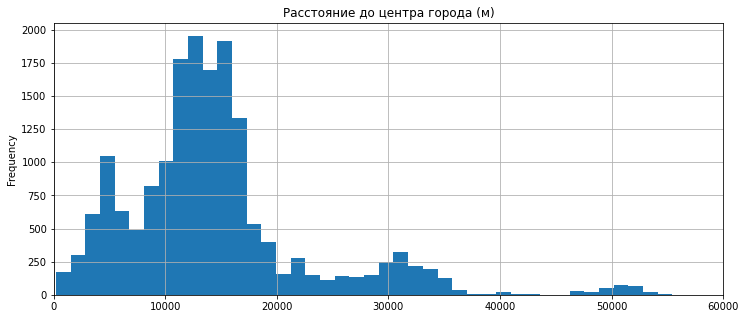

In [25]:
data['cityCenters_nearest'].plot(kind='hist', bins=50, grid=True, title='Расстояние до центра города (м)', xlim=(0,60000), figsize=(12,5))
plt.show()

Чаще всего квартиры расположены на расстоянии 10 - 20 км от центра города. Это говорит о том, что объявлений о продаже квартир в центр, значительно меньше, чем в отдаленных районах. 

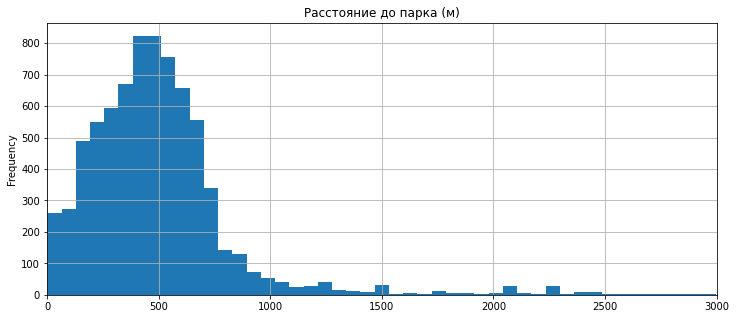

In [26]:
data['parks_nearest'].plot(kind='hist', bins=50, grid=True, title='Расстояние до парка (м)', xlim=(0,3000), figsize=(12,5))
plt.show()

Чаще всего парки находятся на расстоянии 400-500 м от дома. 

count    19678.00
mean       178.21
std        216.28
min          1.00
25%         45.00
50%         94.00
75%        228.00
max       1580.00
Name: days_exposition, dtype: float64

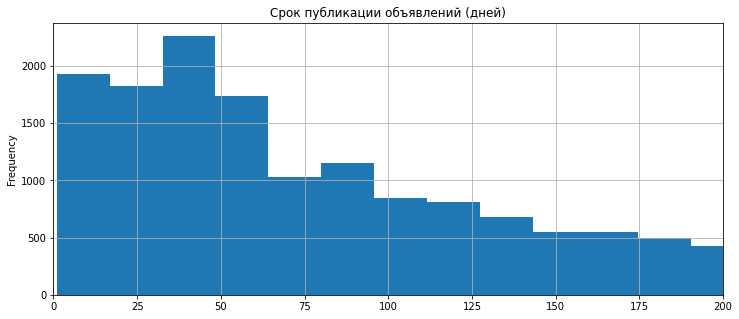

In [27]:
data['days_exposition'].plot(kind='hist', bins=100, grid=True, title='Срок публикации объявлений (дней)', xlim=(0,200), figsize=(12,5))
display(round(data['days_exposition'].describe(), 2))

Обычное время продажи квартир - 40-45 дней. На этот период приходится пик гистограммы. После 60 дней идет резкое падение кол-ва объявлений. \
Быстрыми продажами можно назвать объявления со сроком до 20 дней, слишком долгими - от 60 дней. 

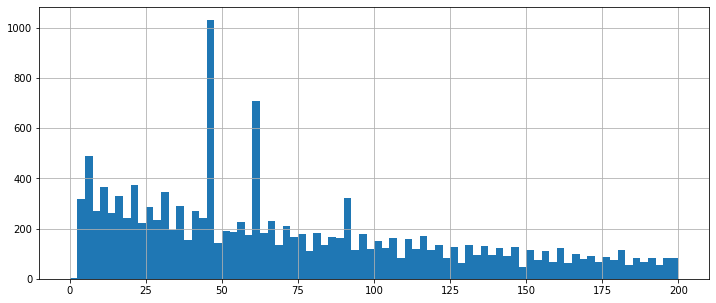

In [40]:
data['days_exposition'].hist(bins = 80, range = (0, 200),
                            figsize = (12, 5));

# Факторы, влияющие на общую(полную) стоимость объекта. 

Коэфициент корреляции цены и общей площади: 0.77


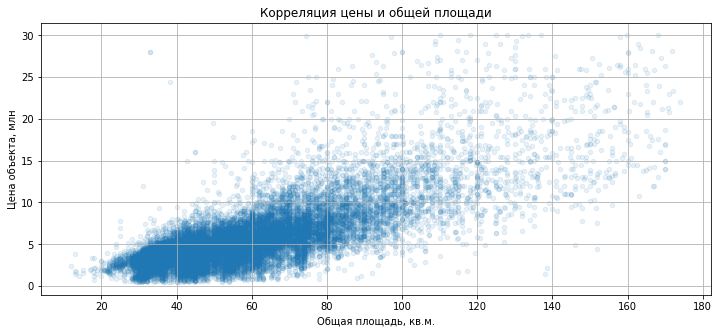

In [28]:
print('Коэфициент корреляции цены и общей площади:', round(data['last_price_bln'].corr(data['total_area']), 2))
#total_area_pivot=data.pivot_table(index='total_area', values='last_price_bln', aggfunc='median')
data.plot(x='total_area', y='last_price_bln', kind='scatter', grid=True, figsize=(12, 5), alpha=0.1)
plt.title('Корреляция цены и общей площади')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Цена объекта, млн')
plt.show()

На основе значения коэффициента и данных графика, можно сделать вывод, что есть при увеличении площади объекта ратет его цена. При этом есть большое количество нетипичных значений, которые отображаютсядля объектов площаью свыше 100 кв.м. и ценой более 15 млн. руб.

Коэфициент корреляции цены и жилой площади: 0.67


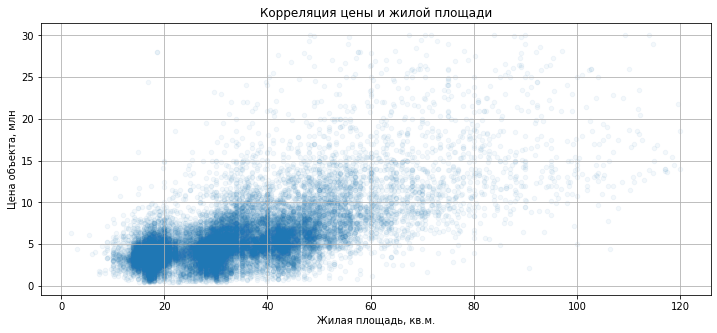

In [29]:
print('Коэфициент корреляции цены и жилой площади:', round(data['last_price_bln'].corr(data['living_area']), 2))
data.plot(x='living_area', y='last_price_bln', kind='scatter', grid=True, figsize=(12, 5), alpha=0.05)
plt.title('Корреляция цены и жилой площади')
plt.xlabel('Жилая площадь, кв.м.')
plt.ylabel('Цена объекта, млн')
plt.show()

На графике хуже видна взаимосвязь между жилой площадью квартиры и ценой. Вероятно это связано с аномалиями в данных. 

Коэфициент корреляции цены и площади кухни: 0.58


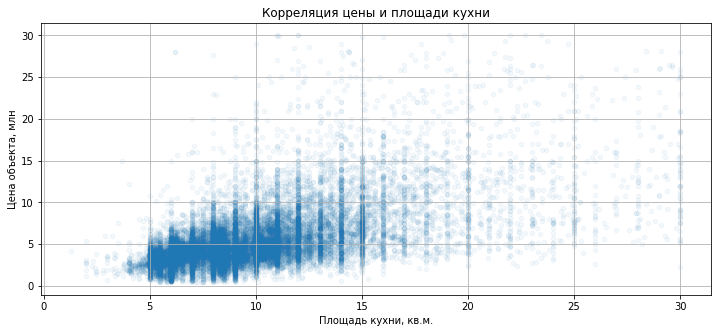

In [30]:
print('Коэфициент корреляции цены и площади кухни:', round(data['last_price_bln'].corr(data['kitchen_area']), 2))
data.plot(x='kitchen_area', y='last_price_bln', kind='scatter', grid=True, figsize=(12, 5), alpha=0.05)
plt.title('Корреляция цены и площади кухни')
plt.xlabel('Площадь кухни, кв.м.')
plt.ylabel('Цена объекта, млн')
plt.show()

График распределения выглядит странно - есть много случаев при которых для одной площади кухни идет большой разброс цен. Это может указывать на то, что взаимосвязь этих показателей есть, но с широким диапазоном значений.  

Коэфициент корреляции цены и количества комнат: 0.48


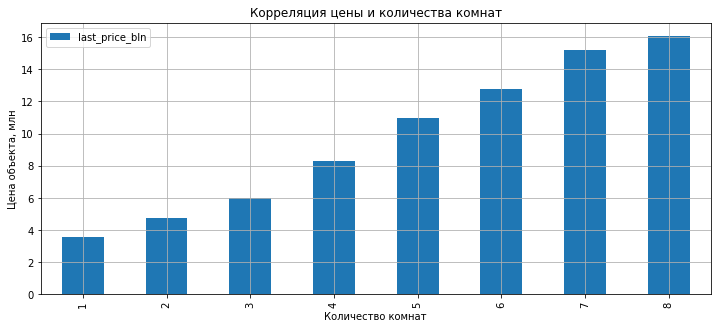

In [31]:
print('Коэфициент корреляции цены и количества комнат:', round(data['last_price_bln'].corr(data['rooms']), 2))
(
    data.pivot_table(index='rooms', values='last_price_bln', aggfunc='median')
    .plot(kind='bar', grid=True, figsize=(12, 5))
)
plt.title('Корреляция цены и количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена объекта, млн')
plt.show()

На графике отчетливо видна зависимость цены от кол-ва комнат - чем больше комнат, тем выше цена. 

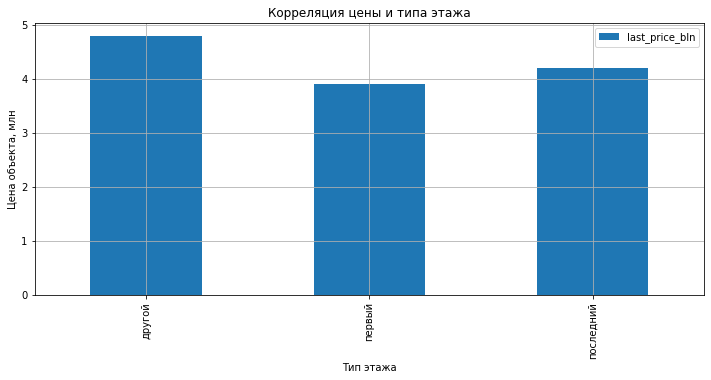

In [32]:
(
    data.pivot_table(index='floor_type', values='last_price_bln', aggfunc='median')
    .plot(kind='bar', grid=True, figsize=(12, 5))
)
plt.title('Корреляция цены и типа этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Цена объекта, млн')
plt.show()

Судя по графику, стоимость квартир незначительно зависит от типа этажа. 

Коэфициент корреляции цены и дня недели: -0.02


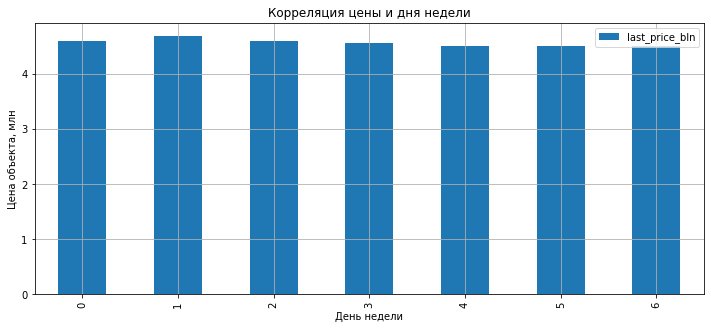

In [33]:
print('Коэфициент корреляции цены и дня недели:', round(data['last_price_bln'].corr(data['week_day']), 2))
(
    data.pivot_table(index='week_day', values='last_price_bln', aggfunc='median')
    .plot(kind='bar', grid=True, figsize=(12, 5))
)
plt.title('Корреляция цены и дня недели')
plt.xlabel('День недели')
plt.ylabel('Цена объекта, млн')
plt.show()

Коэфициент корреляции цены и месяца: 0.01


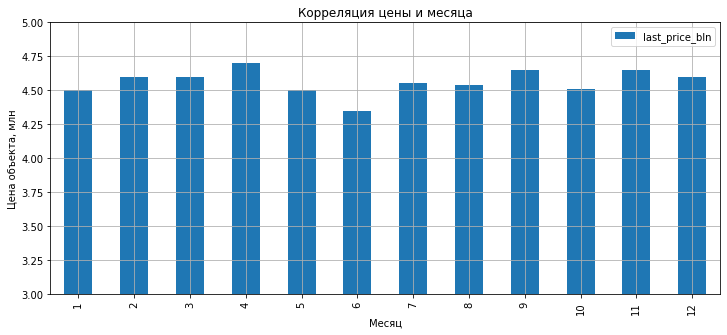

In [34]:
print('Коэфициент корреляции цены и месяца:', round(data['last_price_bln'].corr(data['month']), 2))
(
    data.pivot_table(index='month', values='last_price_bln', aggfunc='median')
    .plot(kind='bar', grid=True, figsize=(12, 5), ylim=(3, 5))
)
plt.title('Корреляция цены и месяца')
plt.xlabel('Месяц')
plt.ylabel('Цена объекта, млн')
plt.show()

Корреляция между месяцем размещения и ценой незначительна, но при масштабировании графика можно увидеть тенденцию сезонности: с января до апреля цены растут, а с мая по июнь есть спад. После снова наблюдается рост с пиком в сентябре. 

Коэфициент корреляции цены и года: -0.02


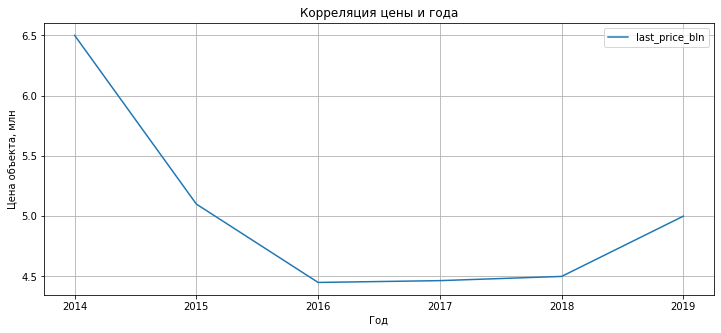

In [35]:
print('Коэфициент корреляции цены и года:', round(data['year'].corr(data['last_price_bln']), 2))
(
    data.pivot_table(index='year', values='last_price_bln', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
)
plt.title('Корреляция цены и года')
plt.xlabel('Год')
plt.ylabel('Цена объекта, млн')
plt.show()

На графике видна тенденция к резкому снижению цены на квартиры к 2016 году, а затем плавный рос до 2019. При этом числовой коэффициент корреляции указывает, что взаимосвязь минимальна. 

# Средняя цена 1 квадратного метра в 10 населённых пунктах

In [36]:
mean_price = data.pivot_table(index='locality_name', values='price_1m', aggfunc=['mean', 'count']).reset_index()
mean_price.columns=['locality_name','mean','count']
mean_price = mean_price.sort_values(by='count', ascending=False).head(10).reset_index()
display(round(mean_price, 2))
max_price = mean_price["mean"].max()
min_price = mean_price["mean"].min()
df_max_price=mean_price[(mean_price['mean']==max_price)]
df_min_price=mean_price[(mean_price['mean']==min_price)]
print(f'Самая высокая стоимость квадратного метра в : {df_max_price["locality_name"]}')
print(f'Самая низкая стоимость квадратного метра в : {df_min_price["locality_name"]}')

,index,locality_name,mean,count
0,305,Санкт-Петербург,110027.38,14869
1,146,Мурино,85027.23,525
2,261,Шушары,78354.14,433
3,275,Всеволожск,68577.10,391
4,304,Пушкин,102678.29,357
5,285,Колпино,75333.30,337
6,164,Парголово,90448.42,322
7,278,Гатчина,68676.46,306
8,115,Кудрово,92369.19,282
9,276,Выборг,57985.15,234


Самая высокая стоимость квадратного метра в : 0    Санкт-Петербург
Name: locality_name, dtype: object
Самая низкая стоимость квадратного метра в : 9    Выборг
Name: locality_name, dtype: object


# Выделить квартиры в Санкт-Петербурге и вычислить их среднюю стоимость на разном удалении от центра

,mean
cityCenters_nearest_km,
0.0,9.91
1.0,11.23
2.0,10.34
3.0,9.39
4.0,9.85
5.0,10.14
6.0,9.19
7.0,9.00
8.0,8.38


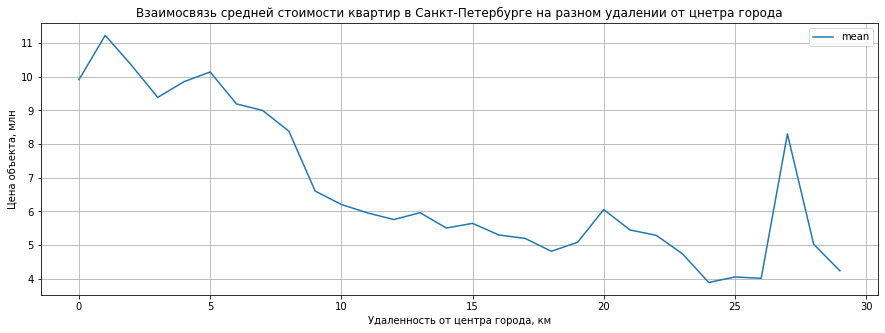

In [37]:
spb_center = data.query('(locality_name == "Санкт-Петербург")&(cityCenters_nearest_km.notnull())')
spb_center_pivot = spb_center.pivot_table(index='cityCenters_nearest_km', values='last_price_bln')
spb_center_pivot.columns=['mean']
display(round(spb_center_pivot, 2))
spb_center_pivot.sort_values('cityCenters_nearest_km').plot( grid=True, figsize=(15, 5))
plt.title('Взаимосвязь средней стоимости квартир в Санкт-Петербурге на разном удалении от цнетра города')
plt.xlabel('Удаленность от центра города, км')
plt.ylabel('Цена объекта, млн')
plt.show()
    

На графике видно, что чем ближе к центру, тем выше средняя цена квартиры. 

In [38]:
display(spb_center.query('cityCenters_nearest_km == 27.0'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_1m,week_day,month,year,floor_type,cityCenters_nearest_km,last_price_bln
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0.0,NaN,128.0,193918.92,1,11,2017,другой,27.0,14.35
5961,6,2250000.0,32.0,2018-02-27,1,2.73,2,16.5,2,False,...,0.0,NaN,178.0,70312.50,1,2,2018,последний,27.0,2.25


# Общий вывод

При изучени данных обнаружено много пропусков и ошибочных значений связанных как с человеческим фактором, так и с ошибками технического характера.\
Для улучшения качества данных рекомендуется:
- прописать инструкции для пользователей в виде всплывающих подсказок о том, как заполнять ту или иную информацию (что считать апартаментами, как рассчитывать высоту потолков,что входит в площадь жилой зоны). 
- настроить алгоритмы сбора информации так, чтобы геопозиция считала точнее данные о близости к центру города, паркам и водоемам.
Были скорректированы данные о высоте потолков, т.к. в датафрейме они были указаны с ошибками(нереалистичные данные с потолками выше 10 м.).\
При анализе отдельных параметров выявлены выбросы нереалистично больших значений площадей и стоимости объектов при небольшой частоте их появления. Для большей наглядности эти данные были удалены.\
\
Обычное время продажи квартир - 40-45 дней. На этот период приходится пик гистограммы. Быстрыми продажами можно назвать объявления со сроком до 20 дней, слишком долгими - от 300 дней.\
\
Изучение корреляции параметров и цены объекта показала, что на цену значительно влияет квадратура объекта, кол-во комнат и год публикации. Практически не влияют на цену - день и месяц размещения объявления и тип этажа.\
\
10 населенных пункта с наибольшим кол-вом объявлений это:Санкт-Петербург, Мурино, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, Кудрово, Выборг. Наибольшая средняя цена 1 квадратного метра в Санкт-Петербурге, наименьшая - в Выборге.\
\
При изучении средней стоимости квартир в Санкт-Петербургена разном удалении от центра можно сделать вывод, что чем ближе к центру, тем дороже квартиры. 

